<a href="https://colab.research.google.com/github/hanumantjain/PyTorch/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the opendatasets library for downloading datasets from Kaggle
!pip install opendatasets --quiet
# Import the opendatasets library
import opendatasets as od
# Download the "animal-faces" dataset from Kaggle
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hanumantjain
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 192MB/s] 


In [2]:
# Import necessary libraries for building and training a neural network
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

# Determine the device to use for training (GPU if available, otherwise CPU)
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [3]:
# Initialize lists to store image paths and corresponding labels
image_path = []
labels = []
# Iterate through the directories to collect image paths and labels
for i in os.listdir("/content/animal-faces/afhq/"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      # Append the image path and label to the respective lists
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

# Create a pandas DataFrame from the collected image paths and labels
data_df = pd.DataFrame(zip(image_path, labels), columns =["image_path", "labels"])
# Print the unique labels in the dataset
print(data_df["labels"].unique())
# Display the first few rows of the DataFrame
data_df.head()

['dog' 'cat' 'wild']


,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [4]:
# Split the data into training, testing, and validation sets
# train: 70% of the data
train = data_df.sample(frac = 0.7)
# test: remaining data after taking the training set
test = data_df.drop(train.index)

# val: 50% of the test set (which is 15% of the total data)
val = test.sample(frac = 0.5)
# test: remaining data after taking the validation set (which is 15% of the total data)
test = test.drop(val.index)

# Print the shapes of the resulting dataframes
print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


In [25]:
# Initialize a LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
# Fit the encoder to the unique labels in the dataset
label_encoder.fit(data_df["labels"])

# Define image transformations to resize and convert images to tensors
transform = transforms.Compose([
    transforms.Resize((128,128)), # Resize images to 128x128 pixels
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # Convert tensor data type to float
])

In [26]:
# Define a custom PyTorch Dataset class for loading image data
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform= None):
    # Initialize the dataset with a dataframe and optional transformations
    self.dataframe = dataframe
    self.transform = transform
    # Encode labels to numerical format and move to the specified device
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    # Return the total number of samples in the dataset
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    # Get the image path and label for a given index
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    # Open and convert the image to RGB format
    image = Image.open(img_path).convert('RGB')

    # Apply transformations if specified
    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [27]:
# Create instances of the CustomImageDataset for training, testing, and validation sets
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)

In [28]:
# Get the number of samples in the training dataset
train_dataset.__len__()

11291

In [29]:
# Get the first item (image and label) from the training dataset
train_dataset.__getitem__(0)

(tensor([[[0.0549, 0.0549, 0.0549,  ..., 0.1529, 0.1490, 0.1490],
          [0.0549, 0.0549, 0.0588,  ..., 0.1529, 0.1490, 0.1490],
          [0.0549, 0.0588, 0.1098,  ..., 0.1608, 0.1569, 0.1529],
          ...,
          [0.0745, 0.0549, 0.0275,  ..., 0.0039, 0.0039, 0.0039],
          [0.0784, 0.0392, 0.0196,  ..., 0.0039, 0.0039, 0.0039],
          [0.0510, 0.0157, 0.0157,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0549, 0.0510, 0.0549,  ..., 0.1529, 0.1490, 0.1490],
          [0.0549, 0.0510, 0.0549,  ..., 0.1529, 0.1490, 0.1490],
          [0.0549, 0.0510, 0.0902,  ..., 0.1608, 0.1569, 0.1529],
          ...,
          [0.0745, 0.0549, 0.0275,  ..., 0.0039, 0.0039, 0.0039],
          [0.0784, 0.0392, 0.0196,  ..., 0.0039, 0.0039, 0.0039],
          [0.0510, 0.0157, 0.0157,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0549, 0.0706, 0.0784,  ..., 0.1529, 0.1490, 0.1490],
          [0.0549, 0.0706, 0.0706,  ..., 0.1529, 0.1490, 0.1490],
          [0.0588, 0.0667, 0.0902,  ...,

In [30]:
# Decode a numerical label back to its original string representation
label_encoder.inverse_transform([1])

array(['dog'], dtype=object)

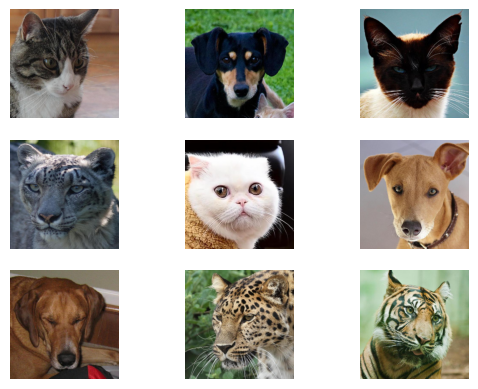

In [31]:
# Display a grid of sample images from the dataset
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    # Select a random image path and open the image
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    # Display the image on the current subplot axis
    axarr[row, col].imshow(image)
    # Turn off the axis for a cleaner look
    axarr[row, col].axis('off')

# Show the plot
plt.show()

In [32]:
# Define hyperparameters for training the model
LR = 1e-4 # Learning rate
BATCH_SIZE = 16 # Batch size for data loaders
EPOCHS = 10 # Number of training epochs

In [33]:
# Create DataLoaders for the training, testing, and validation datasets
# DataLoaders provide an iterable over the dataset, allowing for batch processing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle test data
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle validation data

In [37]:
# Define the Convolutional Neural Network (CNN) model
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # Define convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Input channels: 3 (RGB), Output channels: 32
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input channels: 32, Output channels: 64
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Input channels: 64, Output channels: 128

    # Define max pooling layer
    self.pooling = nn.MaxPool2d(2,2) # 2x2 kernel with stride 2

    # Define activation function
    self.relu = nn.ReLU() # Rectified Linear Unit

    # Define flatten layer to convert convolutional output to a vector
    self.flattern = nn.Flatten()

    # Define fully connected layers
    self.linear = nn.Linear((128*16*16), 128) # Input features: 128 * 16 * 16 (from pooled conv3 output), Output features: 128

    # Define the output layer
    self.output = nn.Linear(128, len(data_df['labels'].unique())) # Input features: 128, Output features: number of unique labels

  def forward(self, x):
    # Define the forward pass of the network
    x = self.conv1(x) # Apply first convolutional layer
    x = self.pooling(x) # Apply max pooling
    x = self.relu(x) # Apply ReLU activation

    x = self.conv2(x) # Apply second convolutional layer
    x = self.pooling(x) # Apply max pooling
    x = self.relu(x) # Apply ReLU activation

    x = self.conv3(x) # Apply third convolutional layer
    x = self.pooling(x) # Apply max pooling
    x = self.relu(x) # Apply ReLU activation

    x = self.flattern(x) # Flatten the output
    x = self.linear(x) # Apply first fully connected layer
    x = self.output(x) # Apply output layer

    return x

In [38]:
# Instantiate the Net model and move it to the specified device
model = Net().to(device)

In [39]:
# Import the summary function from torchsummary
from torchsummary import summary
# Print a summary of the model architecture and parameters
summary(model, input_size= (3, 128, 128)) # Input size: (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [40]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross-entropy loss for classification
optimizer = Adam(model.parameters(), lr = LR) # Adam optimizer with the specified learning rate

In [42]:
# Initialize lists to store loss and accuracy values for plotting
total_loss_train_plot = []
total_loss_validation_plot =[]
total_acc_train_plot = []
total_acc_validation_plot =[]

# Train the model for the specified number of epochs
for epoch in range(EPOCHS):
  # Initialize variables to track loss and accuracy for the current epoch
  total_acc_train = 0
  total_acc_val = 0
  total_loss_train = 0
  total_loss_val = 0

  # Training loop
  for inputs, labels in train_loader:
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Calculate training loss
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

  # Validation loop (no gradient calculation)
  with torch.no_grad():
    for inputs, labels in val_loader:
      # Forward pass
      outputs = model(inputs)
      # Calculate validation loss
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      # Calculate validation accuracy
      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

  # Append epoch loss and accuracy to the plotting lists
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100, 4))
  total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__()) * 100, 4))

  # Print epoch statistics
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss {round(total_loss_train/1000, 4)} Train Accuracy {round((total_acc_train/train_dataset.__len__()) * 100, 4)}
            Validation Loss {round(total_loss_val/1000, 4)} Validation Accuracy {round((total_acc_val/val_dataset.__len__()) * 100, 4)}
        ''')

Epoch 1/10, Train Loss 0.34 Train Accuracy 79.5678
            Validation Loss 0.0369 Validation Accuracy 91.4463
        
Epoch 2/10, Train Loss 0.1388 Train Accuracy 92.897
            Validation Loss 0.0281 Validation Accuracy 93.595
        
Epoch 3/10, Train Loss 0.0887 Train Accuracy 95.74
            Validation Loss 0.0202 Validation Accuracy 95.2479
        
Epoch 4/10, Train Loss 0.064 Train Accuracy 96.8559
            Validation Loss 0.0162 Validation Accuracy 95.9504
        
Epoch 5/10, Train Loss 0.0496 Train Accuracy 97.6176
            Validation Loss 0.0168 Validation Accuracy 96.157
        
Epoch 6/10, Train Loss 0.0352 Train Accuracy 98.2198
            Validation Loss 0.0263 Validation Accuracy 94.4215
        
Epoch 7/10, Train Loss 0.0269 Train Accuracy 98.6892
            Validation Loss 0.0179 Validation Accuracy 96.0331
        
Epoch 8/10, Train Loss 0.0206 Train Accuracy 98.9992
            Validation Loss 0.0192 Validation Accuracy 95.7851
        
Epoch 9/

In [44]:
# Evaluate the model on the test set
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  # Iterate through the test data loader
  for inputs, labels in test_loader:
    # Get predictions from the model
    predictions = model(inputs)

    # Calculate accuracy
    acc = (torch.argmax(predictions, axis=1) ==labels).sum().item()
    total_acc_test += acc

    # Calculate test loss
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

# Print the final test accuracy and loss
print(f"Accuracy {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss {round(total_loss_test/1000, 4)}")

Accuracy 95.618 and Loss 0.0211


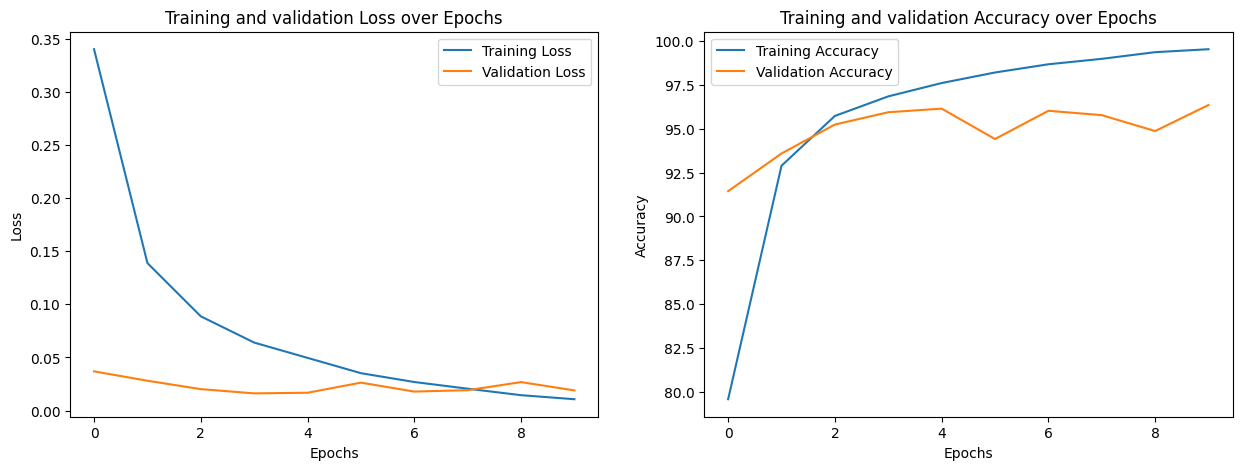

In [51]:
# Create subplots for visualizing training/validation loss and accuracy
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

# Plot training and validation loss
axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Display the plots
plt.show()

In [56]:
# Define a function to predict the animal class of a single image
def predict_image(image_path):
  # Open and transform the image
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  # Print the shape of the transformed image tensor
  print(image.shape)
  # Get the model's output for the image
  output = model(image.unsqueeze(0)) # Add a batch dimension
  # Get the predicted class index
  output = torch.argmax(output, axis=1).item()
  # Decode the predicted class index back to the original label
  return label_encoder.inverse_transform([output])

In [57]:
# Use the predict_image function to predict the class of a sample image
predict_image("/content/images.jpeg")

torch.Size([3, 128, 128])


array(['wild'], dtype=object)